## Setup environment

In [4]:
import matplotlib.pyplot as plt

from simulators.grid_world.grid_world import SimpleGridWorld, simulate_policy
from simulators.grid_world import GAMMA, HORIZON

simple_env = SimpleGridWorld()

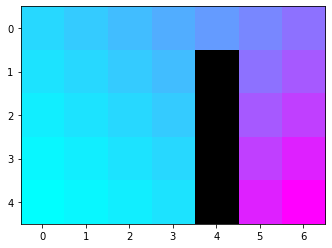

In [5]:
from algorithms.VI_dynamic_programming import value_iteration

Q_expert, expert_policy = value_iteration(simple_env.P, simple_env.R, GAMMA)

# Uncomment if you want to simulate the policy
# simulate_policy(expert_policy, "../../videos/simple_grid_world/expert.mp4", simple_env, HORIZON)

V_expert = Q_expert.max(axis=1)
img = simple_env.get_layout_img(V_expert)    
plt.imshow(img)
plt.show()

In [14]:
np.argmin(V_expert)

0

In [15]:
import numpy as np
import matplotlib.pyplot as plt


class ReplayBuffer:
    def __init__(self, env, epsilon_decay, gamma, regularisor_bellmann):
        self.env = env
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.regularisor_bellmann = regularisor_bellmann

        self.size_feature = env.get_feature(0, 0).shape[0]

        self.buffer = []

        self.A = None  # Grad matrix
        self.b = None  # Grad matrix

    def collect_samples(self, n_samples, w, trajectory):
        state = self.env.initial_state_distribution

        self.env.reset()
        terminal = False

        for idx_sample in range(n_samples):
            if not trajectory:
                state = np.random.choice(self.env._states)
                self.env.state = state
            elif terminal:  # Trajectory case
                self.env.reset()

            # Policy improvement
            if np.random.random() < self.epsilon_decay(len(self.buffer)):
                action = np.random.choice(self.env._actions)
            else:
                action = np.argmax([self.env.get_feature(state, action) @ w for action in self.env._actions])

            next_state, reward, terminal, _ = self.env.step(action)
            next_action = np.argmax([self.env.get_feature(next_state, action) @ w for action in self.env._actions])

            self.buffer.append((state, action, reward, next_state, next_action))
            state = next_state

    def compute_grad_matrices(self):
        features = np.zeros((len(self.buffer), self.size_feature))
        next_features = np.zeros((len(self.buffer), self.size_feature))
        rewards = np.zeros(len(self.buffer))

        for idx_sample, (state, action, reward, next_state, next_action) in enumerate(self.buffer):
            features[idx_sample] = self.env.get_feature(state, action)
            next_features[idx_sample] = self.env.get_feature(next_state, next_action)
            rewards[idx_sample] = reward

        inverse_matrix = np.linalg.inv(
            features.T @ features + self.regularisor_bellmann * len(self.buffer) * np.eye(self.size_feature)
        )
        print("Sum rewards:", sum(rewards))
        self.A = np.eye(self.size_feature) - self.gamma * inverse_matrix @ features.T @ next_features
        self.b = inverse_matrix @ features.T @ rewards

    def statistics_on_samples(self):
        plt.figure()
        number_occurences = np.zeros(self.env.S)

        for (state, _, _, _, _) in self.buffer[-500:]:
            number_occurences[state] += 1
  
        img = self.env.get_layout_img(number_occurences)  
        print("Number of sample on terminal state:", number_occurences[5])  
        plt.title("Statistics on occurences")
        plt.imshow(img)
        plt.show()      


def show_intermediate_result(env, w):
    plt.figure()
    Q = np.zeros((env.S, env.A))

    for state in env._states:
        for action in env._actions:
            Q[state, action] = env.get_feature(state, action) @ w
    
    V = Q.max(axis=1)
    
    print("Value function on terminal node:", V[5])
    print("Value function on initial node:", V[0])
    img = env.get_layout_img(V)    
    plt.imshow(img)
    plt.show()


def lstd(env, n_samples_per_iteration, regularisor, regularisor_bellmann, learning_rate=0.001, trajectory=False, max_iteration=10, tol=1e-1):
    from algorithms.epsilon_greedy import epsilon_decay
    from simulators.grid_world import GAMMA

    replay_buffer = ReplayBuffer(env, epsilon_decay, GAMMA, regularisor_bellmann)

    w = np.random.random(replay_buffer.size_feature)

    for iteration in range(max_iteration):
        # Exploration
        replay_buffer.collect_samples(n_samples_per_iteration, w, trajectory)
        replay_buffer.statistics_on_samples()
        replay_buffer.compute_grad_matrices()

        # Evaluation
        grad = float("inf") * np.ones(w.shape)

        while np.linalg.norm(grad) > tol:
            grad = np.zeros(w.shape)

            for sample in replay_buffer.buffer:
                feature = env.get_feature(sample[0], sample[1])
                grad += (feature.T @ (replay_buffer.A @ w - replay_buffer.b)) * (replay_buffer.A.T @ feature)

            grad = grad / len(replay_buffer.buffer) + regularisor * w

            w -= learning_rate * grad

        # Improvement
        # Done when samples are collected.

        show_intermediate_result(env, w)

    Q = np.zeros((env.S, env.A))

    for state in env._states:
        for action in env._actions:
            Q[state, action] = env.get_feature(state, action) @ w

    return Q, np.argmax(Q, axis=1)

Number of sample on terminal state: 8.0


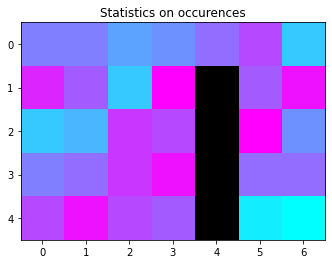

Sum rewards: 8.0
Value function on terminal node: 0.4003068205766261
Value function on initial node: 0.06234603496663935


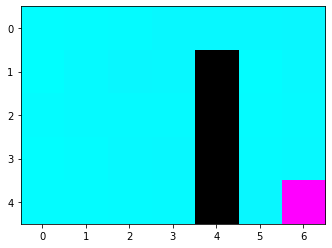

Number of sample on terminal state: 20.0


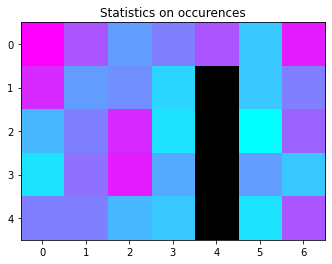

Sum rewards: 28.0
Value function on terminal node: 0.6252737691559987
Value function on initial node: 0.09413949078207764


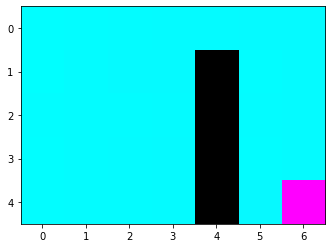

Number of sample on terminal state: 14.0


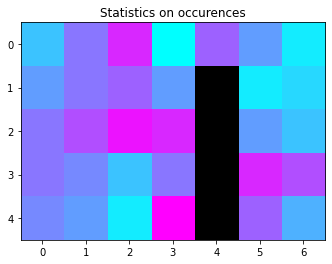

Sum rewards: 42.0
Value function on terminal node: 0.6355480877373794
Value function on initial node: 0.10495162059653412


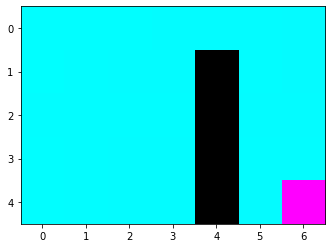

Number of sample on terminal state: 16.0


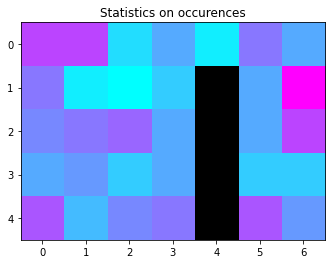

Sum rewards: 58.0
Value function on terminal node: 0.6588245925016528
Value function on initial node: 0.11453534364750227


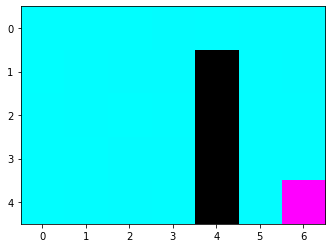

Number of sample on terminal state: 13.0


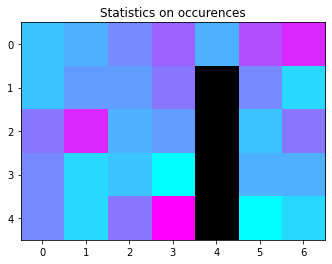

Sum rewards: 71.0
Value function on terminal node: 0.6514326827550978
Value function on initial node: 0.11535067141424254


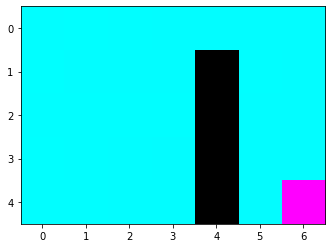

In [16]:
# from algorithms.LSTD import lstd

n_samples_per_iteration = 500
regularisor = 0.01
regularisor_bellmann = 0.01
max_iteration = 5
trajectory = False
tol = 1e-6
learning_rate = 1

Q_lstd, lstd_policy = lstd(simple_env, n_samples_per_iteration, regularisor, regularisor_bellmann, learning_rate=learning_rate, trajectory=trajectory, max_iteration=max_iteration, tol=tol)

# Uncomment if you want to simulate the policy
# simulate_policy(lstd_policy, "../../videos/simple_grid_world/lstd.mp4", simple_env, HORIZON)

In [34]:
Q_lstd

array([[ 1.15350671e-01, -3.74801876e-04, -6.88403427e-03,
         1.14591793e-02],
       [ 1.16752517e-01,  1.02704366e-03, -5.48218873e-03,
         1.28610248e-02],
       [ 1.18107969e-01,  2.38249575e-03, -4.12673665e-03,
         1.42164769e-02],
       [ 1.17577790e-01,  1.85231687e-03, -4.65691552e-03,
         1.36862980e-02],
       [ 1.19835776e-01,  4.11030240e-03, -2.39892999e-03,
         1.59442835e-02],
       [ 6.51432683e-01,  5.35707209e-01,  5.29197977e-01,
         5.47541191e-01],
       [ 1.14709143e-01, -1.01633033e-03, -7.52556272e-03,
         1.08176508e-02],
       [ 1.16193724e-01,  4.68250927e-04, -6.04098147e-03,
         1.23022321e-02],
       [ 1.18740183e-01,  3.01470956e-03, -3.49452283e-03,
         1.48486907e-02],
       [ 1.19345919e-01,  3.62044574e-03, -2.88878666e-03,
         1.54544269e-02],
       [ 1.17077866e-01,  1.35239292e-03, -5.15683948e-03,
         1.31863740e-02],
       [ 1.17876871e-01,  2.15139764e-03, -4.35783475e-03,
      

ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4745:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5233:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2660:(snd_pcm_open_noupdate) Unknown PCM default
ffmpeg version 4.3.3-0+deb11u1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avres

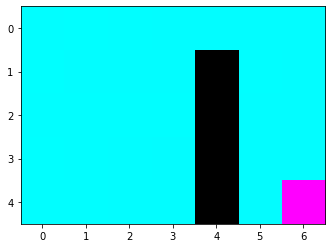

In [18]:
# simulate_policy(lstd_policy, "../../videos/simple_grid_world/lstd.mp4", simple_env, HORIZON)


V_lstd = Q_lstd.max(axis=1)
img = simple_env.get_layout_img(V_lstd)    
plt.imshow(img)
plt.show()